
## Classification
Define  one (or more) classification  task and solve it using:
- KNN with at least two distances: Euclidean/Manhattan/DTW 
- Shapelets: Analyze the shapelets retrieved
- At least one other method (rocket, muse, cnn, rnn etc)


In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

from sktime.transformations.compose import FitInTransform
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder

In [34]:
import pyts
from pyts import classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold

from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from scikitplot.metrics import plot_roc
from sklearn.metrics import confusion_matrix

from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize

LOAD intero

In [35]:
def load_npy(filename):
    return np.load(filename)

In [36]:
# reload 
X_y_ids = load_npy(r'C:\Users\HUAWEI\Desktop\DM2\project NEW\output_data\X_y_ids.npz') 
X, y, ids = X_y_ids['arr_0'], X_y_ids['arr_1'], X_y_ids['arr_2']

In [37]:
X = X.squeeze()
X.shape

(10000, 1280)

In [38]:
def moving_average_smoothing(series, window_size):
    """
    Perform moving average smoothing on a single time series.
    
    series: Input time series as a 1-dimensional numpy array.
    window_size: Size of the moving window as an integer.
    
    Returns the smoothed time series.
    """
    window = np.ones(window_size) / window_size
    smoothed_series = np.convolve(series, window, mode='same')
    return smoothed_series

#tss_scal_smot = tss_scal.copy()

w = 10 #che valore di w usare?

for i,time_series in enumerate(X):
    X[i]= moving_average_smoothing(X[i], w)

In [39]:
#temporaneo 
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

print(X.shape)
X = TimeSeriesScalerMeanVariance().fit_transform(X)
X = X.squeeze()
print(X.shape)

(10000, 1280)
(10000, 1280)


In [40]:
from pyts.approximation import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from pyts.approximation import DiscreteFourierTransform

print(X.shape)
#-------------------------#-------------------------
window_size = 4
paa = PiecewiseAggregateApproximation(window_size=window_size)
X_paa = paa.transform(X)
print(X_paa.shape)

#-------------------------#-------------------------
## SAX with 50 symbols and 500 segments - erano quelli che plottando la TS davano risultato migliore
n_sax_symbols = 10
sax = SymbolicAggregateApproximation(n_segments=500, alphabet_size_avg=n_sax_symbols) #, scale=True
X_sax = sax.fit_transform(X)
X_sax = X_sax.squeeze()
print(X_sax.shape)

#-------------------------#-------------------------
n_coefs = 64
dft = DiscreteFourierTransform(n_coefs=n_coefs)
X_dft = dft.fit_transform(X)
print(X_dft.shape)

(10000, 1280)
(10000, 320)


c:\Users\HUAWEI\anaconda3\Lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 10000 1-dimensional timeseries
  warnings.warn(


(10000, 500)
(10000, 64)


In [9]:
# #variare il caricamento X_scal X_sax, X_paa, X_dft

# X_dft = np.load(r'C:\Users\HUAWEI\Desktop\DM2\project NEW\output_data\X_dft.npy')
# X_paa = np.load(r'C:\Users\HUAWEI\Desktop\DM2\project NEW\output_data\X_paa.npy')
# X_sax= np.load(r'C:\Users\HUAWEI\Desktop\DM2\project NEW\output_data\X_sax.npy')

# y = np.loadtxt(r'C:\Users\HUAWEI\Desktop\DM2\project NEW\output_data\y.txt', dtype=str)
# X_dft.shape, X_paa.shape, X_sax.shape, y.shape

RAW

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 1280), (2000, 1280), (8000,), (2000,))

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15, 30, 50, 75, 100],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}

In [43]:
#alleno il modello con i migliori parametri:
knn = KNeighborsClassifier(p= 2, n_neighbors= 5, weights="distance", n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.137
F1-score 0.10953566163716562
                   precision    recall  f1-score   support

              emo      0.087     0.020     0.033       100
             folk      0.153     0.090     0.113       100
             goth      0.019     0.010     0.013       100
            happy      0.158     0.380     0.223       100
      heavy-metal      0.051     0.020     0.029       100
       honky-tonk      0.146     0.060     0.085       100
           j-idol      0.154     0.100     0.121       100
             kids      0.212     0.070     0.105       100
   minimal-techno      0.265     0.450     0.333       100
              mpb      0.143     0.050     0.074       100
          new-age      0.074     0.170     0.103       100
            opera      0.050     0.060     0.055       100
            piano      0.063     0.080     0.071       100
progressive-house      0.141     0.290     0.190       100
            salsa      0.250     0.070     0.109       100
        ser

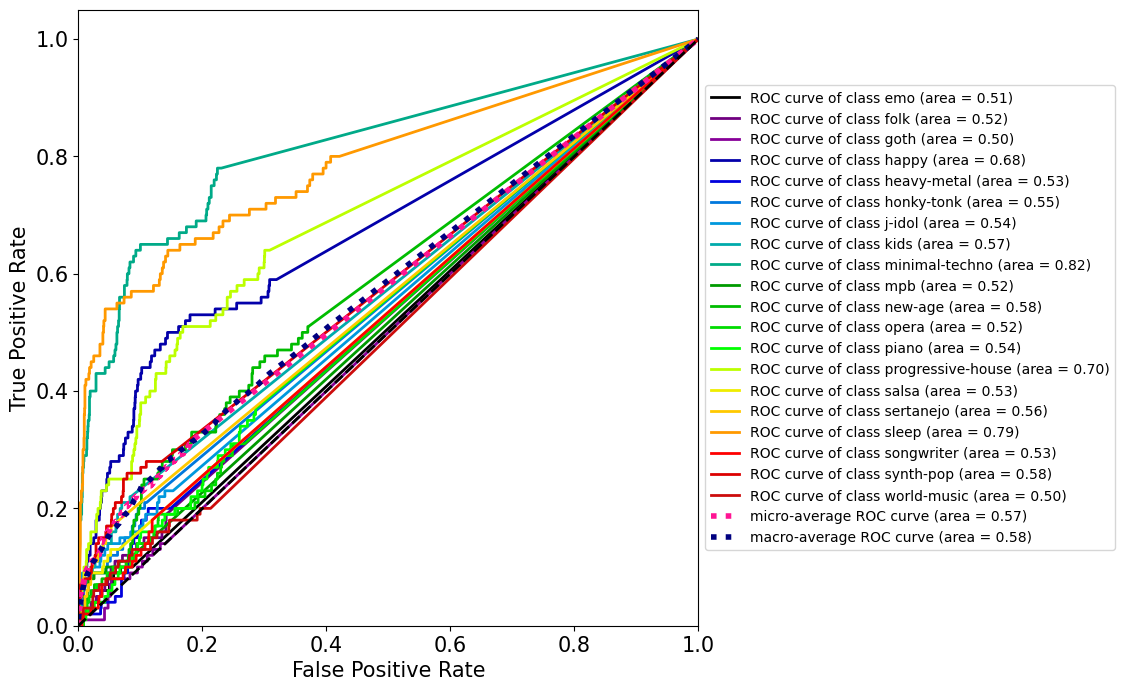

In [44]:
y_score = knn.predict_proba(X_test)

plot_roc(y_test, y_score, figsize=(8,8), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


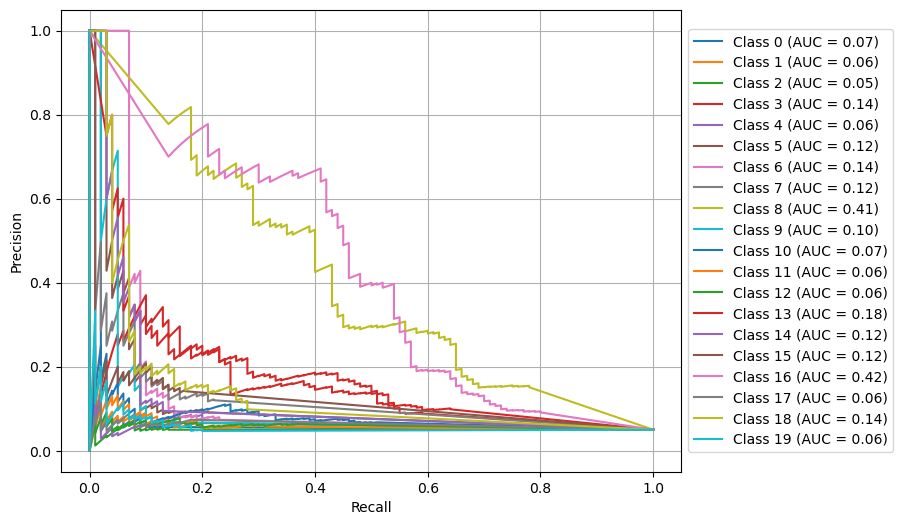

In [45]:
# Make predictions on test data
y_pred_proba = knn.predict_proba(X_test)  # Probability estimates of each class

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_binarized.shape[1]

# Compute precision and recall for each class
precision = dict()
recall = dict()
thresholds = dict()
auc_score = dict()

for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score[i] = auc(recall[i], precision[i])

# Plot precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AUC = {auc_score[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.title('Precision-Recall Curve for Multiclass Classification')
#plt.legend(loc='lower left')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()


array([[ 2,  4,  4, 13,  3,  1,  4,  1,  2,  1, 12,  6,  6, 11,  1,  3,
        13,  3,  2,  8],
       [ 1,  9,  3, 10,  2,  3,  3,  4,  6,  2,  5,  9,  5,  5,  0,  1,
        15, 13,  1,  3],
       [ 2,  1,  1, 13,  4,  6,  2,  3,  8,  1,  9, 10,  7,  7,  2,  0,
        13,  0,  6,  5],
       [ 0,  1,  1, 38,  0,  0,  1,  0,  8,  0, 10,  8,  0, 15,  0,  0,
        14,  1,  3,  0],
       [ 0,  1,  5, 20,  2,  1,  4,  1,  4,  3, 10,  7,  6,  6,  2,  1,
        23,  1,  1,  2],
       [ 4,  0,  4,  5,  2,  6,  2,  0,  6,  3, 13, 11, 10,  9,  2,  0,
        14,  2,  6,  1],
       [ 1,  1,  1, 15,  3,  3, 10,  2,  6,  0,  7,  4,  8,  7,  1,  0,
        25,  1,  2,  3],
       [ 2,  4,  3,  8,  2,  3,  6,  7,  7,  4, 12,  8,  5,  7,  2,  2,
        10,  1,  7,  0],
       [ 1,  2,  0, 10,  1,  3,  2,  3, 45,  0,  2,  1,  1, 17,  1,  0,
         8,  1,  1,  1],
       [ 3,  5,  4, 15,  2,  3,  3,  0,  3,  5, 14,  7,  3,  6,  1,  2,
        11,  3,  5,  5],
       [ 0,  0,  2, 13,  1,  1

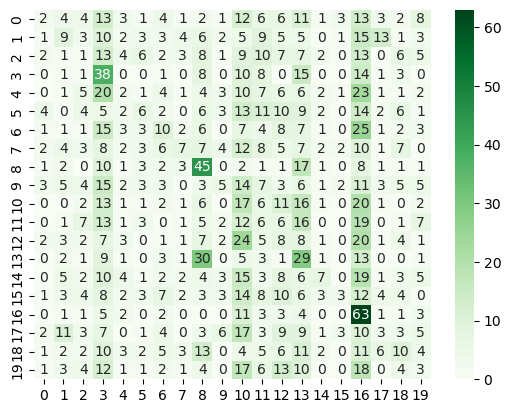

In [46]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Greens")
cm

### Classification approssimazione DFT

In [47]:
#y = LabelEncoder().fit_transform(y)

X = X_dft.copy()
X

array([[-1.98063788e-13,  1.83686614e+01, -8.46239218e+01, ...,
        -3.77907744e+00, -2.42441133e+01, -4.48503109e+01],
       [-3.03757020e-13, -1.44491645e+02, -1.08566273e+00, ...,
        -4.15019931e+01,  1.49650305e+02,  1.41515765e+02],
       [-1.97619698e-13, -5.44003679e+02, -5.63719724e+01, ...,
         2.88906939e+00,  3.14720588e+01, -1.54217049e+01],
       ...,
       [ 5.75539616e-13,  1.82655148e+02, -1.55137904e+02, ...,
         5.35108780e+01,  8.43024448e+01, -2.03693446e+01],
       [-7.07656156e-13, -2.15738335e+02, -8.91855096e+01, ...,
        -7.60787861e+01,  3.63217559e+00, -1.55975227e-01],
       [-4.20996571e-13,  4.76816102e+01, -1.48336149e+02, ...,
        -1.90135617e+01,  2.91077705e+01, -2.72498938e+00]])

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 64), (2000, 64), (8000,), (2000,))

In [49]:
# df = pd.DataFrame(np.squeeze(X_train))
# df["genre"] = y_train

euclidean/manhattan

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15, 30, 50],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}

In [51]:
#alleno il modello con i migliori parametri:
knn = KNeighborsClassifier(p=2, n_neighbors=1, weights="uniform", n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.1
F1-score 0.07515354815016696
                   precision    recall  f1-score   support

              emo      0.043     0.010     0.016       100
             folk      0.023     0.010     0.014       100
             goth      0.038     0.010     0.016       100
            happy      0.113     0.260     0.158       100
      heavy-metal      0.053     0.020     0.029       100
       honky-tonk      0.100     0.050     0.067       100
           j-idol      0.294     0.100     0.149       100
             kids      0.097     0.060     0.074       100
   minimal-techno      0.071     0.700     0.129       100
              mpb      0.182     0.040     0.066       100
          new-age      0.083     0.020     0.032       100
            opera      0.053     0.010     0.017       100
            piano      0.033     0.010     0.015       100
progressive-house      0.124     0.230     0.161       100
            salsa      0.094     0.030     0.045       100
        serta

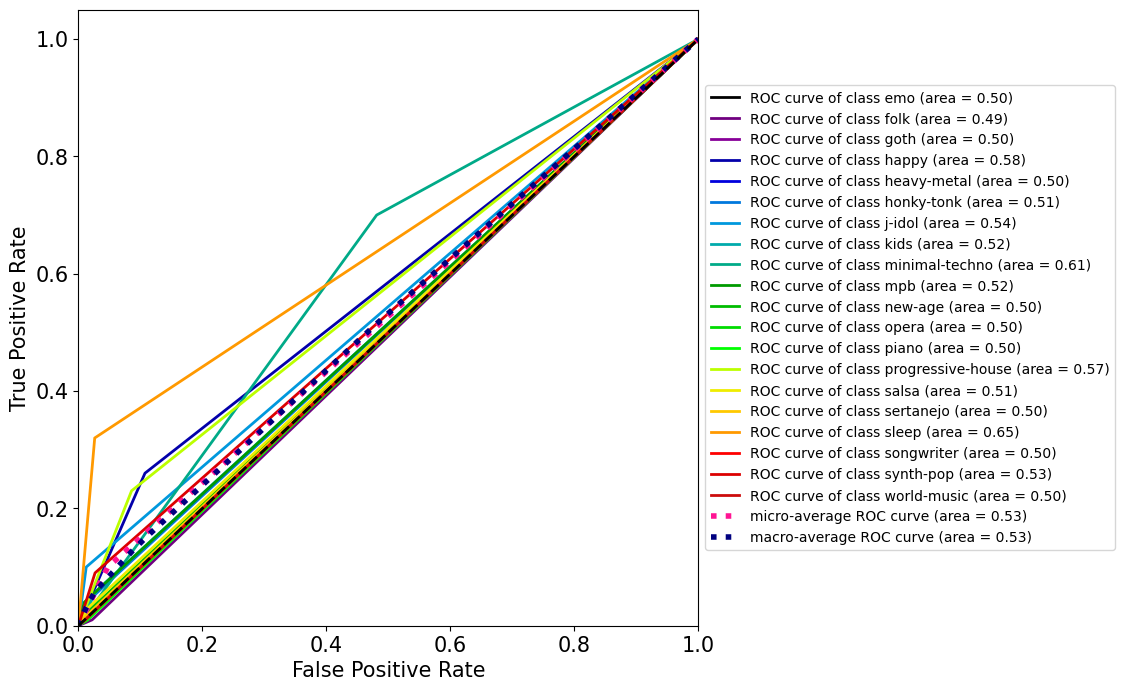

In [52]:
y_score = knn.predict_proba(X_test)

plot_roc(y_test, y_score, figsize=(8,8), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


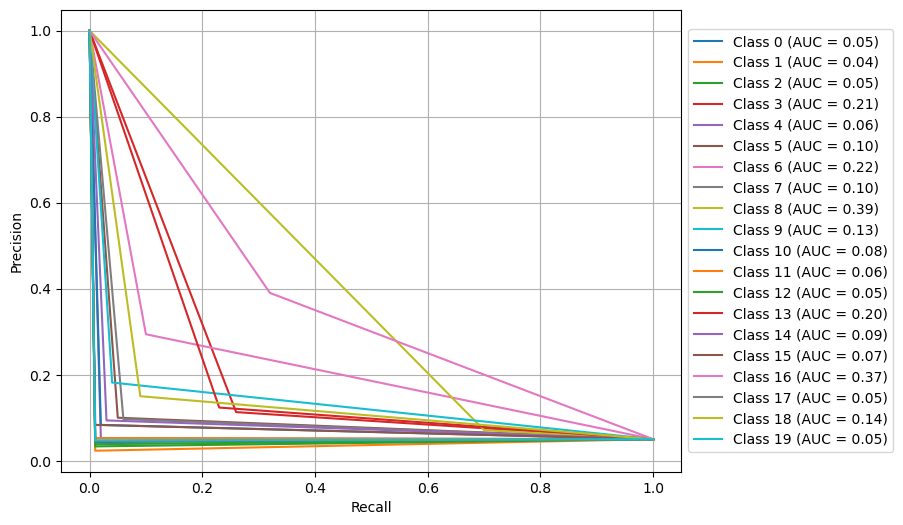

In [53]:
# Make predictions on test data
y_pred_proba = knn.predict_proba(X_test)  # Probability estimates of each class

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_binarized.shape[1]

# Compute precision and recall for each class
precision = dict()
recall = dict()
thresholds = dict()
auc_score = dict()

for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score[i] = auc(recall[i], precision[i])

# Plot precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AUC = {auc_score[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.title('Precision-Recall Curve for Multiclass Classification')
#plt.legend(loc='lower left')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()


array([[ 2,  0,  7,  5, 34, 12,  8,  0,  4,  0,  2,  5,  1,  0,  1,  1,
        15,  1,  1,  1],
       [ 2,  2,  5,  5, 16, 15,  0,  0,  4,  0,  8,  9,  0,  0,  0,  0,
        23, 11,  0,  0],
       [ 0,  0,  4,  0, 39,  6,  6,  0,  5,  0,  4,  6,  0,  0,  0,  1,
        29,  0,  0,  0],
       [ 1,  0,  0, 47, 14,  1,  3,  0,  0,  0,  0,  0,  0,  4,  0,  0,
        30,  0,  0,  0],
       [ 0,  0,  3,  7, 56,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        32,  0,  0,  0],
       [ 0,  2,  5,  1, 10, 27,  0,  0, 10,  0, 13, 10,  0,  0,  0,  0,
        22,  0,  0,  0],
       [ 0,  0,  4, 10, 25,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        54,  0,  0,  0],
       [ 0,  3,  5, 14, 38,  5,  4,  0,  2,  0,  0,  4,  0,  1,  0,  1,
        21,  0,  0,  2],
       [ 0,  1,  5,  7, 25,  8,  3,  0, 16,  0, 13,  6,  0,  2,  0,  0,
        14,  0,  0,  0],
       [ 1,  2, 10,  1, 32, 13,  3,  0,  4,  2,  2,  8,  0,  0,  0,  0,
        21,  0,  0,  1],
       [ 0,  0,  0,  1,  5,  4

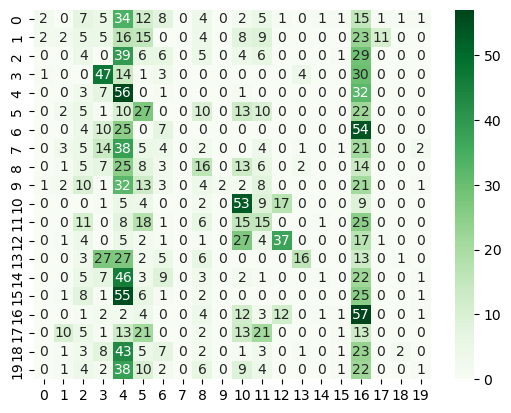

In [26]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Greens")
cm

### Classification approssimazione PAA

In [67]:
#y = LabelEncoder().fit_transform(y)
X = X_paa.copy()
X

array([[-1.87585123,  1.50598159,  1.55320175, ...,  0.96700035,
         0.35610136, -2.10131551],
       [-2.4618904 , -1.55723244, -1.32187952, ..., -0.72303113,
        -0.11698174, -0.15659344],
       [-2.08843532, -0.6451628 , -0.55089958, ..., -0.19065696,
        -0.49290997, -1.93429039],
       ...,
       [-2.07663234,  0.02869242,  0.3898006 , ...,  0.08276985,
        -0.63406441, -1.87807505],
       [-4.80946148, -1.87352853, -1.4275455 , ..., -2.12381636,
        -2.01670237, -4.15189643],
       [-4.01905786, -1.13163725, -1.29035195, ...,  0.57636164,
        -0.48256907, -3.14109263]])

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 320), (2000, 320), (8000,), (2000,))

In [56]:
# df = pd.DataFrame(np.squeeze(X_train))
# df["genre"] = y_train

euclidean/manhattan

In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15, 30, 50],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}

In [69]:
#cambiare nome modello

#alleno il modello con i migliori parametri:
knn = KNeighborsClassifier(p= 2, n_neighbors= 5, weights="distance", n_jobs=-1)
knn.fit(X_train, y_train)

y_pred= knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.1385
F1-score 0.11024413461758689
                   precision    recall  f1-score   support

              emo      0.100     0.020     0.033       100
             folk      0.108     0.070     0.085       100
             goth      0.069     0.040     0.051       100
            happy      0.153     0.380     0.218       100
      heavy-metal      0.073     0.030     0.043       100
       honky-tonk      0.136     0.060     0.083       100
           j-idol      0.169     0.110     0.133       100
             kids      0.132     0.050     0.072       100
   minimal-techno      0.250     0.480     0.329       100
              mpb      0.152     0.050     0.075       100
          new-age      0.077     0.150     0.102       100
            opera      0.050     0.050     0.050       100
            piano      0.071     0.080     0.075       100
progressive-house      0.132     0.280     0.179       100
            salsa      0.189     0.070     0.102       100
        se

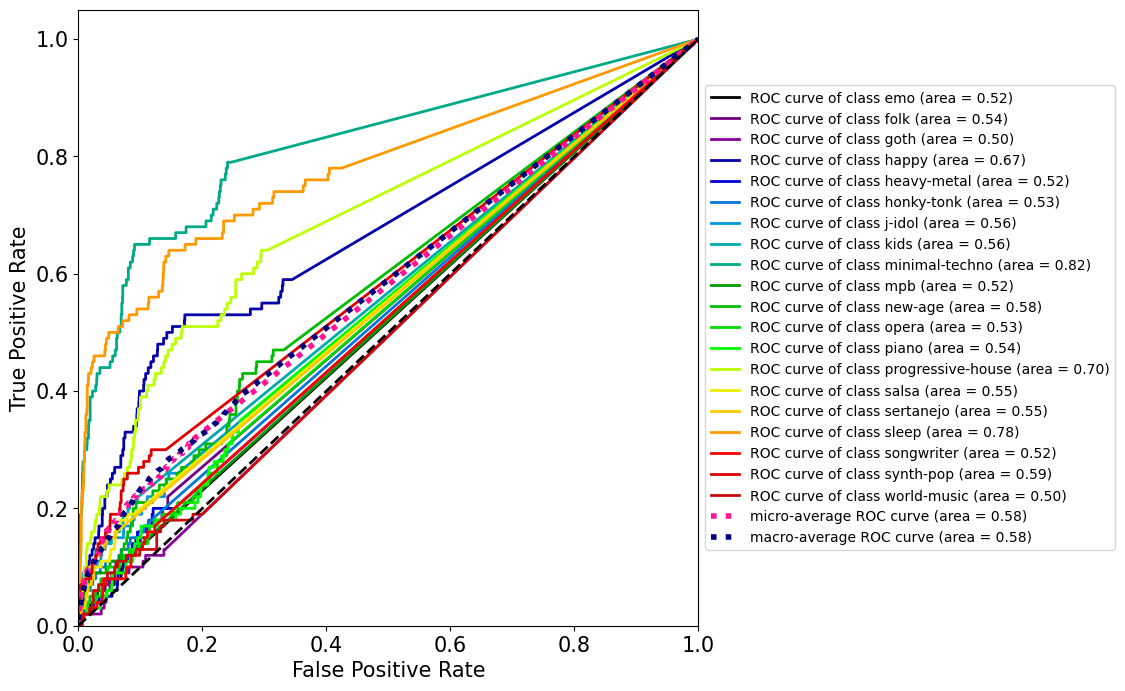

In [70]:
y_score = knn.predict_proba(X_test)

plot_roc(y_test, y_score, figsize=(8,8), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


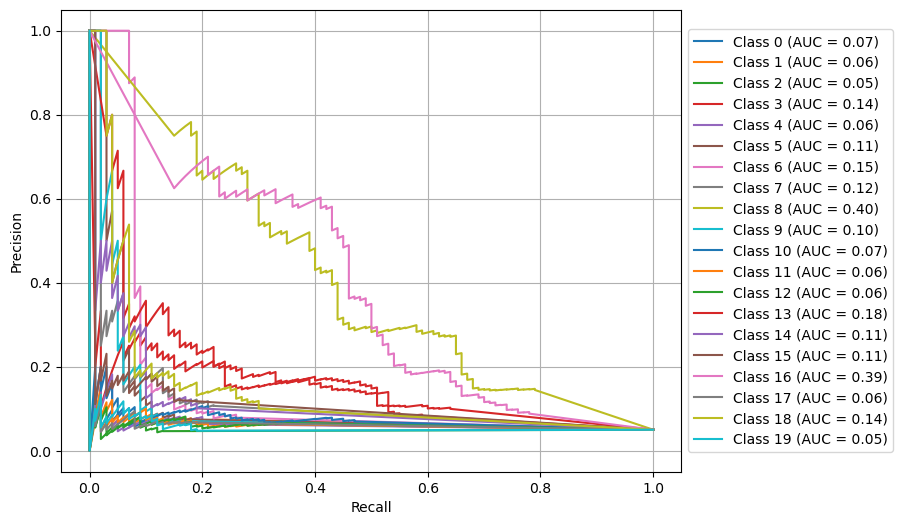

In [71]:
# Make predictions on test data
y_pred_proba = knn.predict_proba(X_test)  # Probability estimates of each class

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_binarized.shape[1]

# Compute precision and recall for each class
precision = dict()
recall = dict()
thresholds = dict()
auc_score = dict()

for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score[i] = auc(recall[i], precision[i])

# Plot precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AUC = {auc_score[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.title('Precision-Recall Curve for Multiclass Classification')
#plt.legend(loc='lower left')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()


<Axes: >

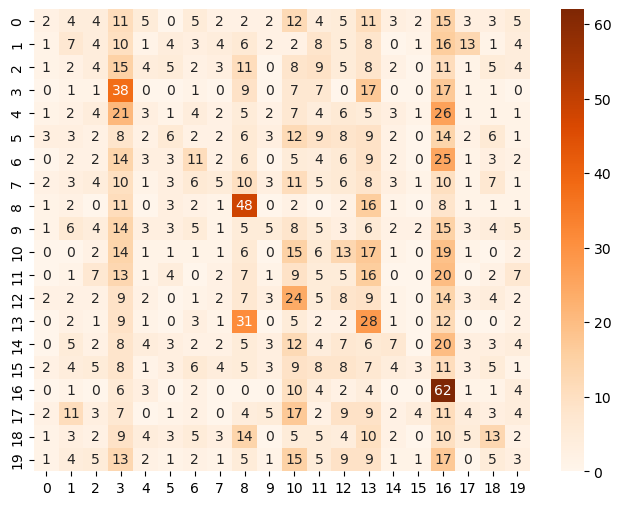

In [80]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))  # Modifica le dimensioni qui
sns.heatmap(cm, annot=True, cmap="Oranges")

### Classification approssimazione SAX


In [62]:
#y = LabelEncoder().fit_transform(y)
X = X_sax.copy()
X

array([[0, 1, 8, ..., 5, 5, 5],
       [0, 0, 0, ..., 2, 1, 0],
       [0, 0, 2, ..., 2, 2, 2],
       ...,
       [0, 0, 4, ..., 2, 0, 0],
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 1, ..., 6, 6, 7]])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 500), (2000, 500), (8000,), (2000,))

In [64]:
# df = pd.DataFrame(np.squeeze(X_train))
# df["genre"] = y_train

euclidean/manhattan

In [65]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [1, 3, 5, 10, 15, 30, 50],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for the Minkowski metric (1: Manhattan distance, 2: Euclidean distance)
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

In [66]:

#alleno il modello con i migliori parametri:
knn = KNeighborsClassifier(p= 1, n_neighbors= 5, weights="distance", n_jobs=-1)
knn.fit(X_train, y_train)

y_pred= knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.1205
F1-score 0.10388613330271164
                   precision    recall  f1-score   support

              emo      0.111     0.020     0.034       100
             folk      0.044     0.030     0.036       100
             goth      0.000     0.000     0.000       100
            happy      0.115     0.360     0.174       100
      heavy-metal      0.029     0.010     0.015       100
       honky-tonk      0.174     0.080     0.110       100
           j-idol      0.259     0.070     0.110       100
             kids      0.273     0.060     0.098       100
   minimal-techno      0.316     0.430     0.364       100
              mpb      0.156     0.050     0.076       100
          new-age      0.102     0.100     0.101       100
            opera      0.042     0.080     0.055       100
            piano      0.061     0.180     0.091       100
progressive-house      0.175     0.290     0.218       100
            salsa      0.143     0.010     0.019       100
        se

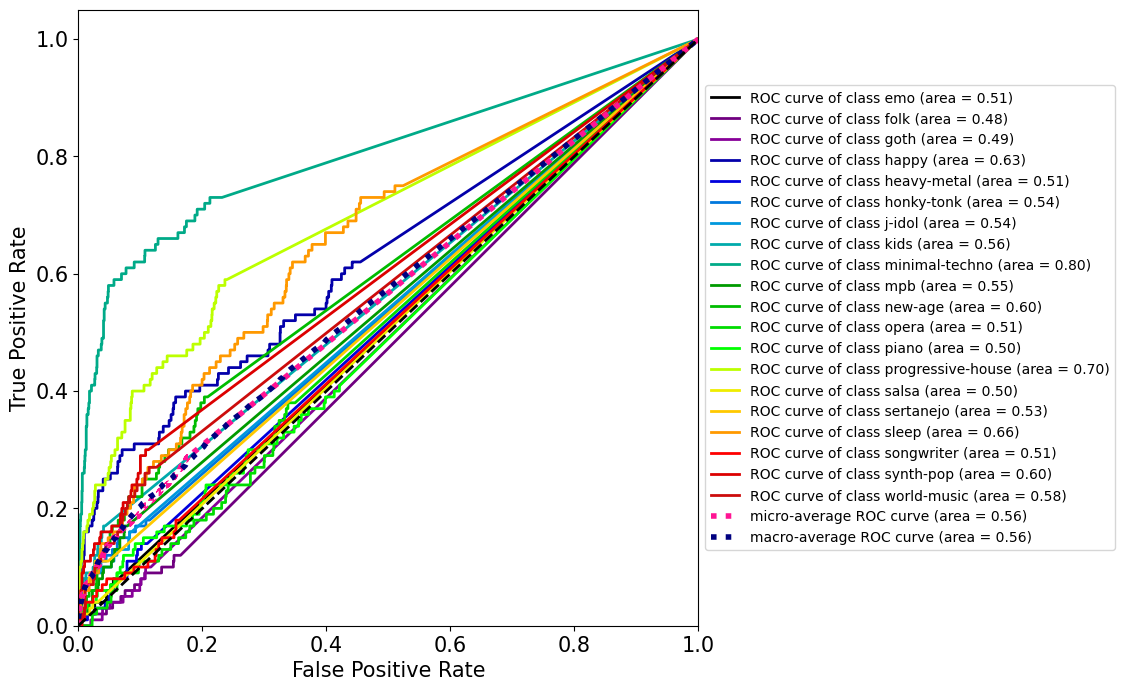

In [176]:
y_score = knn.predict_proba(X_test)

plot_roc(y_test, y_score, figsize=(8,8), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


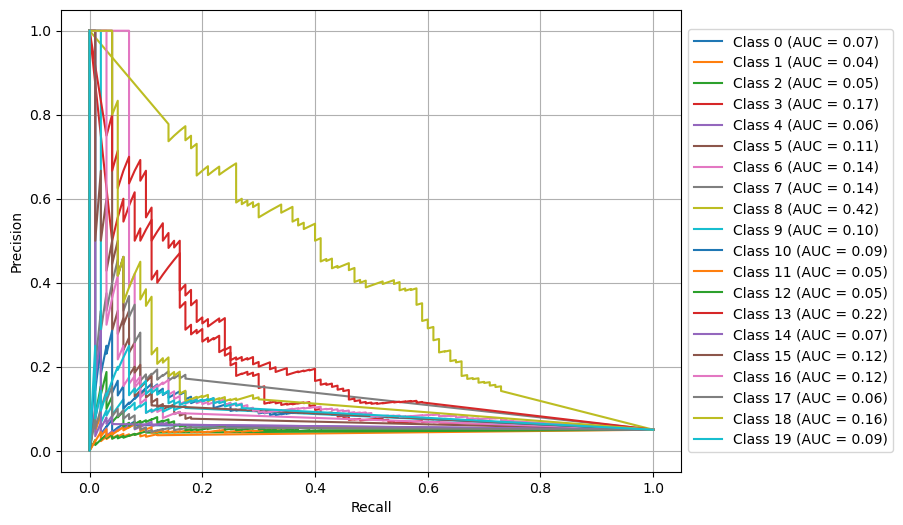

In [177]:
# Make predictions on test data
y_pred_proba = knn.predict_proba(X_test)  # Probability estimates of each class

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_binarized.shape[1]

# Compute precision and recall for each class
precision = dict()
recall = dict()
thresholds = dict()
auc_score = dict()

for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score[i] = auc(recall[i], precision[i])

# Plot precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AUC = {auc_score[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.title('Precision-Recall Curve for Multiclass Classification')
#plt.legend(loc='lower left')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()


array([[ 2,  9,  1, 14,  1,  2,  2,  1,  3,  2,  6, 14, 20,  3,  0,  0,
        13,  3,  1,  3],
       [ 2,  3,  0, 19,  1,  3,  2,  1,  3,  0,  4,  8, 17,  3,  0,  0,
        17, 13,  2,  2],
       [ 0,  5,  0, 16,  3,  3,  1,  2,  1,  4,  1, 11, 20,  9,  0,  0,
        16,  2,  2,  4],
       [ 0,  1,  0, 36,  1,  1,  1,  0,  6,  3,  4,  7, 11, 13,  0,  0,
        15,  0,  0,  1],
       [ 3,  3,  6, 15,  1,  5,  2,  2,  4,  2,  2,  9, 14,  4,  2,  0,
        23,  0,  2,  1],
       [ 1,  3,  1, 10,  0,  8,  2,  2,  3,  0,  4, 11, 20,  6,  2,  0,
        21,  3,  3,  0],
       [ 1,  1,  0, 17,  4,  3,  7,  1,  4,  2,  5, 13, 14,  6,  0,  0,
        15,  2,  3,  2],
       [ 1,  1,  0, 15,  0,  1,  1,  6,  8,  2,  2, 10, 15,  6,  0,  1,
        23,  2,  5,  1],
       [ 0,  2,  0,  8,  2,  2,  0,  2, 43,  0,  0,  2,  4, 22,  1,  0,
         7,  0,  5,  0],
       [ 1,  4,  2, 16,  0,  2,  2,  0,  1,  5,  4, 12, 15,  7,  0,  1,
        19,  1,  4,  4],
       [ 1,  0,  0, 12,  1,  1

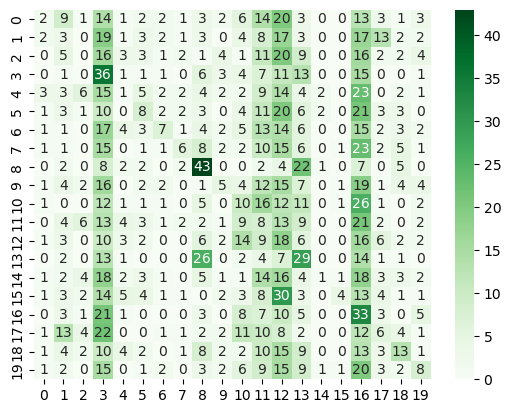

In [178]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Greens")
cm

# classification deep learning

uso il migliore tra quelli prima e basta ---> PAA

At least one other method (rocket, muse, cnn, rnn etc)


<h3>ROCKET</h3>

In [81]:
from sklearn.linear_model import RidgeClassifierCV

In [82]:
#Nota: per rocket serve versione di Numpy precedente alla 1.22, io ho messo la 1.21:
#!pip install numpy==1.21.0
from sktime.transformations.panel.rocket import Rocket

In [83]:
X_paa.shape

(10000, 320)

In [84]:
X = X_paa.copy()
X

array([[-1.87585123,  1.50598159,  1.55320175, ...,  0.96700035,
         0.35610136, -2.10131551],
       [-2.4618904 , -1.55723244, -1.32187952, ..., -0.72303113,
        -0.11698174, -0.15659344],
       [-2.08843532, -0.6451628 , -0.55089958, ..., -0.19065696,
        -0.49290997, -1.93429039],
       ...,
       [-2.07663234,  0.02869242,  0.3898006 , ...,  0.08276985,
        -0.63406441, -1.87807505],
       [-4.80946148, -1.87352853, -1.4275455 , ..., -2.12381636,
        -2.01670237, -4.15189643],
       [-4.01905786, -1.13163725, -1.29035195, ...,  0.57636164,
        -0.48256907, -3.14109263]])

In [85]:
#y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 320), (2000, 320), (8000,), (2000,))

In [86]:
#Rocket univariate -> ci deve essere una sola colonna
x_train_dftEmb = X_train.reshape(8000,1,320)
x_test_dftEmb = X_test.reshape(2000,1,320)

In [87]:
#RUN in 5 min

rocket = Rocket()
rocket.fit(x_train_dftEmb)
x_train_transform_rocket = rocket.transform(x_train_dftEmb)
x_test_transform_rocket = rocket.transform(x_test_dftEmb)

In [88]:
clf_R = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10)) 
clf_R.fit(x_train_transform_rocket, y_train)

RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]))

In [92]:
print('F1-score %s' % f1_score(y_test, clf_R.predict(x_test_transform_rocket), average='weighted'))
print()
print(classification_report(y_test, clf_R.predict(x_test_transform_rocket),digits=3))

F1-score 0.22218043863876508

                   precision    recall  f1-score   support

              emo      0.064     0.060     0.062       100
             folk      0.072     0.060     0.066       100
             goth      0.082     0.070     0.076       100
            happy      0.481     0.510     0.495       100
      heavy-metal      0.189     0.170     0.179       100
       honky-tonk      0.185     0.170     0.177       100
           j-idol      0.215     0.200     0.207       100
             kids      0.101     0.110     0.105       100
   minimal-techno      0.509     0.590     0.546       100
              mpb      0.097     0.100     0.099       100
          new-age      0.238     0.310     0.270       100
            opera      0.154     0.200     0.174       100
            piano      0.121     0.110     0.115       100
progressive-house      0.306     0.340     0.322       100
            salsa      0.300     0.240     0.267       100
        sertanejo      0.

 ## CNN

In [93]:
X = X_paa.copy()
y_labenc = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_labenc, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 320), (2000, 320), (8000,), (2000,))

In [94]:
from sktime.classification.deep_learning import CNNClassifier

import tensorflow as tf
from tensorflow import keras

##### Using sktime
easier, but there is no option to monitor the val loss to check for overfitting

In [95]:
cnn = CNNClassifier(
    n_epochs=10,
    batch_size=16,
    n_conv_layers=2,
    metrics=["accuracy"],
    random_state=42,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="loss")],
)

In [96]:
%%time
cnn.fit(X_train, y_train)
cnn.score(X_test, y_test)

c:\Users\HUAWEI\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(





125/125 [==============================] - 0s 2ms/step
CPU times: total: 8.06 s
Wall time: 10.9 s


0.1595

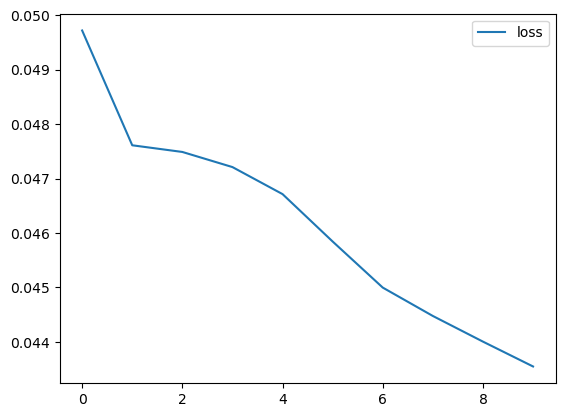

In [97]:
sns.lineplot(cnn.history.history["loss"], label="loss")
plt.show()

##### Using keras

In [98]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D, LeakyReLU
from keras.layers import Activation, Conv1D, BatchNormalization
from keras.callbacks import EarlyStopping

In [99]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()

    model.add(
        Conv1D(
            filters=16, kernel_size=8, activation="relu", input_shape=(n_timesteps, 1)
        )
    )
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=32, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(n_outputs, activation="sigmoid"))
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        metrics=["accuracy"],
    )

    return model

In [100]:
# X_train_cnn = np.swapaxes(X_train, 1, 2)
# X_test_cnn = np.swapaxes(X_test, 1, 2)

# n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train)), 1
# print("TIMESTEPS: ", n_timesteps)
# print("N. LABELS: ", n_outputs)

In [101]:
n_timesteps = 320
n_outputs = 20

cnn = build_simple_cnn(n_timesteps, n_outputs)
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 313, 16)           144       
                                                                 
 batch_normalization (Batch  (None, 313, 16)           64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 313, 16)           0         
                                                                 
 dropout (Dropout)           (None, 313, 16)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 309, 32)           2592      
                                                                 
 batch_normalization_1 (Bat  (None, 309, 32)           128       
 chNormalization)                                       

In [102]:
es = EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)
callbacks = [es]

In [104]:
 #16 min

%%time  
cnn.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    validation_split=0.3,
)

Epoch 1/100
350/350 [==============================] - 6s 13ms/step - loss: 3.0003 - accuracy: 0.0634 - val_loss: 2.9715 - val_accuracy: 0.0779
Epoch 2/100
350/350 [==============================] - 4s 11ms/step - loss: 2.9065 - accuracy: 0.0893 - val_loss: 2.8751 - val_accuracy: 0.1221
Epoch 3/100
350/350 [==============================] - 4s 12ms/step - loss: 2.8525 - accuracy: 0.1155 - val_loss: 2.8317 - val_accuracy: 0.1375
Epoch 4/100
350/350 [==============================] - 4s 12ms/step - loss: 2.8145 - accuracy: 0.1345 - val_loss: 2.8027 - val_accuracy: 0.1396
Epoch 5/100
350/350 [==============================] - 4s 11ms/step - loss: 2.7857 - accuracy: 0.1450 - val_loss: 2.7751 - val_accuracy: 0.1429
Epoch 6/100
350/350 [==============================] - 4s 12ms/step - loss: 2.7578 - accuracy: 0.1548 - val_loss: 2.7563 - val_accuracy: 0.1504
Epoch 7/100
350/350 [==============================] - 4s 11ms/step - loss: 2.7382 - accuracy: 0.1657 - val_loss: 2.7346 - val_accuracy:

In [105]:
summary = pd.DataFrame(cnn.history.history)
summary

,loss,accuracy,val_loss,val_accuracy
0,3.000324,0.063393,2.971477,0.077917
1,2.906465,0.089286,2.875108,0.122083
2,2.852529,0.115536,2.831681,0.137500
3,2.814535,0.134464,2.802693,0.139583
4,2.785726,0.145000,2.775074,0.142917
...,...,...,...,...
95,2.265209,0.296607,2.282041,0.308333
96,2.269716,0.298929,2.285455,0.310417
97,2.263762,0.300536,2.275870,0.312083
98,2.267993,0.302679,2.276095,0.312917


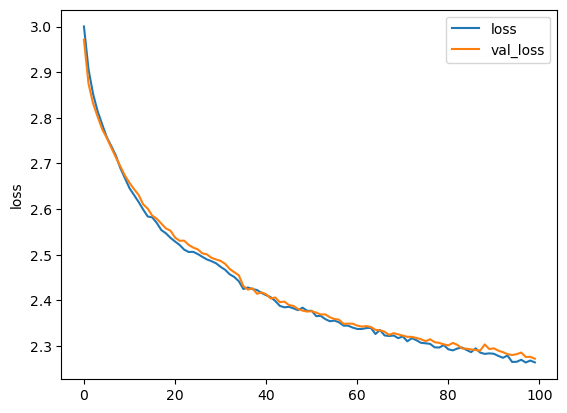

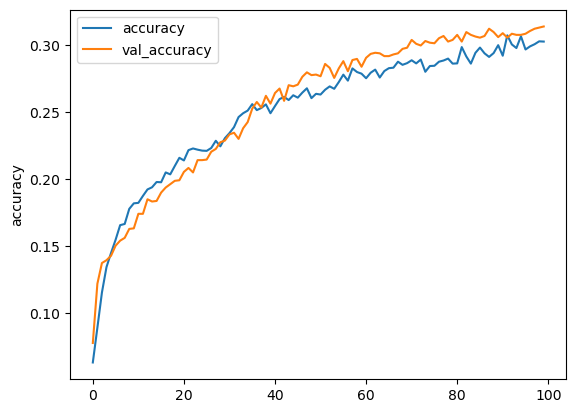

In [106]:
sns.lineplot(summary["loss"], label="loss")
sns.lineplot(summary["val_loss"], label="val_loss")
plt.show()

sns.lineplot(summary["accuracy"], label="accuracy")
sns.lineplot(summary["val_accuracy"], label="val_accuracy")
plt.show()

In [107]:
from sklearn.metrics import accuracy_score

y_pred = np.argmax(cnn.predict(X_test), axis=1)
print("Accuracy %s" % accuracy_score(y_test, y_pred))

63/63 [==============================] - 0s 4ms/step
Accuracy 0.3165


In [109]:
from sklearn.metrics import classification_report


print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print()
print(classification_report(y_test, y_pred, digits=3))


F1-score 0.2886170019181038

              precision    recall  f1-score   support

           0      0.250     0.140     0.179       100
           1      0.000     0.000     0.000       100
           2      0.000     0.000     0.000       100
           3      0.593     0.670     0.629       100
           4      0.255     0.410     0.314       100
           5      0.173     0.240     0.201       100
           6      0.333     0.330     0.332       100
           7      0.230     0.200     0.214       100
           8      0.530     0.620     0.571       100
           9      0.125     0.020     0.034       100
          10      0.333     0.460     0.387       100
          11      0.391     0.430     0.410       100
          12      0.194     0.260     0.222       100
          13      0.398     0.430     0.413       100
          14      0.441     0.600     0.508       100
          15      0.220     0.570     0.318       100
          16      0.590     0.460     0.517       10